Adjusted search removing source bias

This work borrows heavily from the code base at: https://github.com/ccatalao/covid19vaccine-emotions/blob/master/olstorm.ipynb

In [1]:
import tweepy
import snscrape.modules.twitter as sntwitter
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
import ssl

In [2]:
search_df = pd.read_csv('search_data.csv')
search_df.head()

,project,start,five_year_mark,end_date,handle,country
0,Konza tech,2013-01-01,2018-01-01,2020-12-31,konzatech,Kenya
1,Eko Atlantic,2009-01-01,2014-01-01,2020-12-31,EkoAtlantic,Nigeria
2,Waterfall City,2006-01-01,2011-01-01,2020-12-31,WaterfallCityZA,South Africa
3,Hope city,2013-01-01,2018-01-01,2020-12-31,NaN,Ghana
4,Vision city,2013-01-01,2018-01-01,2020-12-31,thevisioncity,Rwanda


In [3]:
# Code adapted from https://medium.datadriveninvestor.com/how-to-build-a-twitter-scraping-app-with-python-b3fc069a19c6
def create_data_file(idx, first_5=True, maxTweets = 100000):
    project, start, five_year_mark, end_date, handle, country = list(search_df.iloc[idx])
    print(project, "5" if first_5 else "")
    
    csvFile = open(f"tweets/{project}{'_5' if first_5 else ''}.csv", 'a', newline='', encoding='utf8')

    csvWriter = csv.writer(csvFile)
    csvWriter.writerow(['id','datetime', 'username', 'tweets'])

    # Query with 'smart city'
    query1 = f'{str.lower(project)} "smart city" lang:en since:{str(start if first_5 else five_year_mark).strip()} until:{str(five_year_mark if first_5 else end_date).strip()}'
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query1).get_items()):
        print('# singular downloaded tweets:', i, end='\r')
        if i > maxTweets :
            break
        if handle != tweet.username:
            csvWriter.writerow([str(tweet.id)+"", tweet.date, tweet.username, tweet.content])
    
    print() #throw in one blank line
    
    # Query with 'smart cities'
    query2 = f'{str.lower(project)} "smart cities" lang:en since:{str(start if first_5 else five_year_mark).strip()} until:{str(five_year_mark if first_5 else end_date).strip()}'
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query2).get_items()):
        print('# plural downloaded tweets:', i, end='\r')
        if i > maxTweets :
            break
        if handle != tweet.username:
            csvWriter.writerow([str(tweet.id)+"", tweet.date, tweet.username, tweet.content])
        
    # Query with country
    query3 = f'{str.lower(project)} {country} lang:en since:{str(start if first_5 else five_year_mark).strip()} until:{str(five_year_mark if first_5 else end_date).strip()}'
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query3).get_items()):
        print('# country downloaded tweets:', i, end='\r')
        if i > maxTweets :
            break
        if handle != tweet.username:
            csvWriter.writerow([str(tweet.id)+"", tweet.date, tweet.username, tweet.content])
        
    csvFile.close()
    print("\ndone")
    print() #throw in one blank line

In [4]:
# maxTweets = 1000

for i in range(len(search_df)):
    create_data_file(i, True)# first 5
    create_data_file(i, False)# after the first 5

Konza tech 5
# singular downloaded tweets: 6
# country downloaded tweets: 312
done

Konza tech 
# singular downloaded tweets: 97
# country downloaded tweets: 84
done

Eko Atlantic 5
# singular downloaded tweets: 7
# country downloaded tweets: 498
done

Eko Atlantic 
# singular downloaded tweets: 88
# country downloaded tweets: 3904
done

Waterfall City 5


done

Waterfall City 
# singular downloaded tweets: 43
# country downloaded tweets: 170
done

Hope city 5
# singular downloaded tweets: 6
# country downloaded tweets: 1325
done

Hope city 
# singular downloaded tweets: 1
# country downloaded tweets: 150
done

Vision city 5
# singular downloaded tweets: 21
# country downloaded tweets: 536
done

Vision city 
# singular downloaded tweets: 2
# country downloaded tweets: 219
done



Get the replies to the tweets we have downloadedfor sentiment analysis as well

In [5]:
# def get_and_append_replies(tweets_file_path, api):
#     df = pd.read_csv(tweets_file_path)
#     original_length = len(df)
#     project = tweets_file_path[:-4] if (not '_5' in tweets_file_path) else tweets_file_path[:-6]
#     for i in range(original_length):
#         name = df.iloc[i]['username']
#         tweet_id = df.iloc[i]['id']
        
#         replies=[]
#         # for tweet in tweepy.Cursor(api.search,q='to:'+name, result_type='mixed', timeout=999999).items(1000):
#         for tweet in tweepy.Cursor(api.search,q='to:EkoAtlantic', result_type='mixed', timeout=999999).items(1000):
#             if hasattr(tweet, 'in_reply_to_status_id_str'):
#                 if (tweet.in_reply_to_status_id_str==tweet_id):
#                     replies.append(tweet)
                    
#         if len(replies)>0:
#             print(replies)
#             break

In [6]:
# # Get tweepy access details
# from secret import *

In [7]:
# # Adapted from https://github.com/nirholas/Get-Tweet-Replies-With-Python-Tweepy/blob/master/twitter_reply.py
# # For getting tweet replies it is easier to use tweepy than snscrape because of some known issues

# ssl._create_default_https_context = ssl._create_unverified_context

# # Oauth keys
# consumer_key = API_KEY
# consumer_secret = API_SECRET
# access_token = ACCESS_TOKEN
# access_token_secret = ACCESS_TOKEN_SECRET

# # Authentication with Twitter
# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_token_secret)
# api = tweepy.API(auth)

# for file in os.listdir('tweets'):
#     get_and_append_replies(f'tweets/{file}', api)
#     break

Emotions: anger, fear, anticipation, trust, surprise, sadness, joy, disgust

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [9]:
import string
import re  # for regular expressions

In [10]:
from collections import defaultdict

In [11]:
STOPLIST = set(stopwords.words('english'))
SYMBOLS = set(" ".join(string.punctuation).split(" ") + \
["-", "...", "”", "``", ",", ".", ":", "''","#","@"])

In [12]:
# The NLTK lemmatizer and stemmer classes
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

In [13]:
# Use the POS tagging from NLTK to retain only adjectives, verbs, adverbs 
# and nouns as a base for for lemmatization.
def get_lemmas(tweet): 
    
    # A dictionary to help convert Treebank tags to WordNet
    treebank2wordnet = {
        'NN':'n', # noun
        'JJ':'a', # adjective
        'VB':'v', # verb
        'RB':'r'  # adverb
    }
    
    postag = ''
    lemmas_list = []
    
    for word, tag in pos_tag(word_tokenize(tweet)):
        if tag.startswith("JJ")     \
            or tag.startswith("RB") \
            or tag.startswith("VB") \
            or tag.startswith("NN"):
                
            try:
                postag = treebank2wordnet[tag[:2]] # get the base form of tag
            except:
                postag = 'n'                
                            
            lemmas_list.append(lemmatizer.lemmatize(word.lower(), postag))    
    
    return lemmas_list

Pre-process the tweets, following a pipeline of tokenization, filtering, case normalization and lemma extraction, including an overall cleaning of html and other codes.

In [14]:
# This is the function to clean and filter the tokens in each tweet
def clean_tweet(tokens):
    
    filtered = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if token not in STOPLIST:
                if token[0] not in SYMBOLS:
                    if not token.startswith('http'):
                        if  '/' not in token:
                            if  '-' not in token:
                                filtered.append(token)
                                        
    return filtered

Prior to lemmatization, apply POS (part-of-speech) tagging to make sure that only the adjectives, verbs, adverbs and nouns are retained.

In [15]:
# Starts the lemmatization process
def get_lemmatized(tweet):
   
    all_tokens_string = ''
    filtered = []
    tokens = []

    # lemmatize
    tokens = [token for token in get_lemmas(tweet)]
    
    # filter
    filtered = clean_tweet(tokens)

    # join everything into a single string
    all_tokens_string = ' '.join(filtered)
    
    return all_tokens_string

In [16]:
for file in os.listdir('tweets'):
    print("Processing", file)
    df = pd.read_csv(f'tweets/{file}')
    
    # get the lemmatized tweets and puts the result in an "edited" text column
    # for future use in this script
    edited_tweets = []
    for tweet in df['tweets']:
        edited = get_lemmatized(tweet)
        if len(edited) > 0:
            edited_tweets.append(edited)
        else:
            edited_tweets.append(None)
    df['edited'] = edited_tweets
    
    # After lemmatization, some tweets may end up with the same words
    # Let's make sure that we have no duplicates
    df.drop_duplicates(subset=['edited'], inplace=True)
    df.dropna(inplace=True)
    
    # save newly edited df back to its file
    df.to_csv(f'tweets/{file}', index=False)

Processing Eko Atlantic.csv
Processing Eko Atlantic_5.csv
Processing Hope city.csv
Processing Hope city_5.csv
Processing Konza tech.csv
Processing Konza tech_5.csv
Processing Vision city.csv
Processing Vision city_5.csv
Processing Waterfall City.csv
Processing Waterfall City_5.csv


Vader sentiment analysis:

In [17]:
# Calling VADER
analyzer = SentimentIntensityAnalyzer()

The output of VADER are the positive, negative, and neutral ratios of sentiment. The most useful metric in VADER is the Compound score. Basically, it is calculated by a sum of the scores of each word, normalized to yeld values between -1, the most extreme negative score, and +1, the most extreme positive.

From this normalized score, I will then create a categorical variable ("sentiment"), with an output of positive, negative and neutral ratios of sentiment, using the following thresholds:

Positive sentiment : (compound score >= 0.05).

Neutral sentiment : (compound score > -0.05) and (compound score < 0.05).

Negative sentiment : (compound score <= -0.05)

In [18]:
# This function returns the sentiment category
def get_sentiment(intensity):
    if intensity >= 0.05:
        return 'Positive'
    elif (intensity >= -0.05) and (intensity < 0.05):
        return 'Neutral'
    else:
        return 'Negative'

In [19]:
# Let's create a list of the emotions
emotions = ['Anger', 'Anticipation','Disgust','Fear', 'Joy','Sadness', 'Surprise', 'Trust']

In [20]:
# Importing the data from the NCR lexicon
ncr = pd.read_csv('ncr_lexicon.csv', sep =';')

In [21]:
def join_edited_string(edited_tweets):
    
    edited_string = ''
    for row in edited_tweets:
        edited_string = edited_string + ' ' + row
        
    return edited_string

In [22]:
def get_tweet_emotions(df, emotions, col):

    df_tweets = df.copy()
    
    emo_info = {'emotion':'' , 'emo_frq': defaultdict(int) }    

    list_emotion_counts = []

    # creating a dictionary list to hold the frequency of the words
    # contributing to the emotions
    for emotion in emotions:
        emo_info = {}
        emo_info['emotion'] = emotion
        emo_info['emo_frq'] = defaultdict(int)
        list_emotion_counts.append(emo_info)
    
    # bulding a zeros matrix to hold the emotions data
    df_emotions = pd.DataFrame(0, index=df.index, columns=emotions)

    
    # stemming the word to facilitate the search in NRC
    stemmer = SnowballStemmer("english")
    
    # iterating in the tweets data set
    for i, row in df_tweets.iterrows(): # for each tweet ...
        tweet = word_tokenize(df_tweets.loc[i][col])
        for word in tweet: # for each word ...
            word_stemmed = stemmer.stem(word.lower())
            # check if the word is in NRC
            result = ncr[ncr.English == word_stemmed]
            # we have a match
            if not result.empty:
                # update the tweet-emotions counts
                for idx, emotion in enumerate(emotions):
                    df_emotions.at[i, emotion] += result[emotion]
                    
                    # update the frequencies dictionary list
                    if result[emotion].any():
                        try:
                            list_emotion_counts[idx]['emo_frq'][word_to_ind[word]] += 1
                        except:
                            continue
    
    # append the emotions matrix to the tweets data set
    df_tweets = pd.concat([df_tweets, df_emotions], axis=1)

    return df_tweets, list_emotion_counts

Processing Eko Atlantic.csv


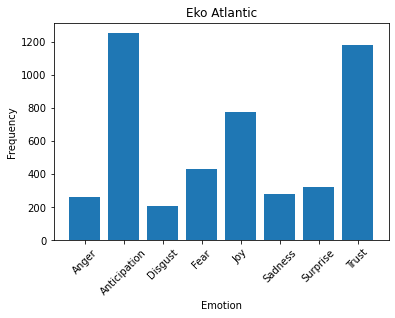

Processing Eko Atlantic_5.csv


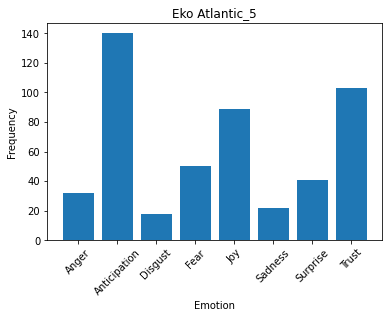

Processing Hope city.csv


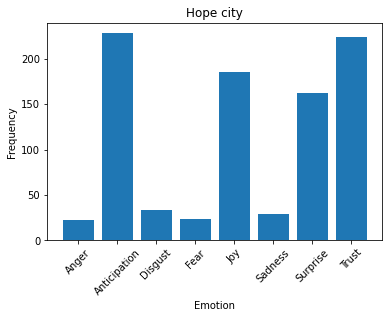

Processing Hope city_5.csv


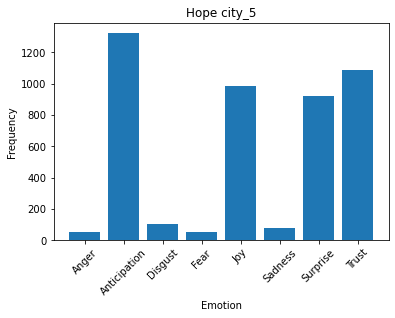

Processing Konza tech.csv


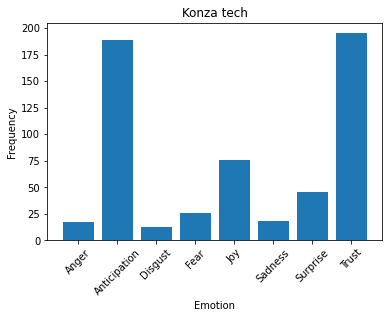

Processing Konza tech_5.csv


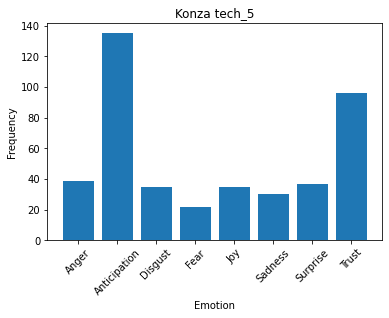

Processing Vision city.csv


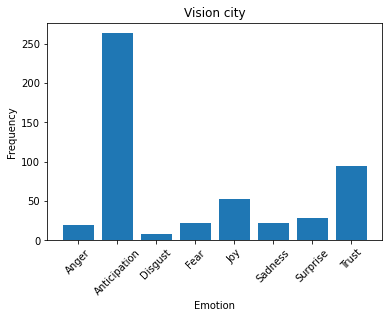

Processing Vision city_5.csv


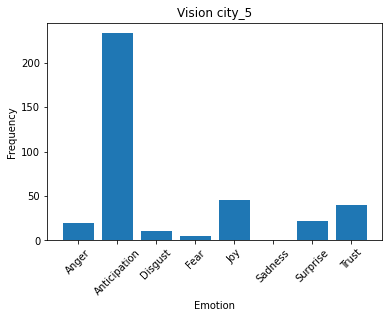

Processing Waterfall City.csv


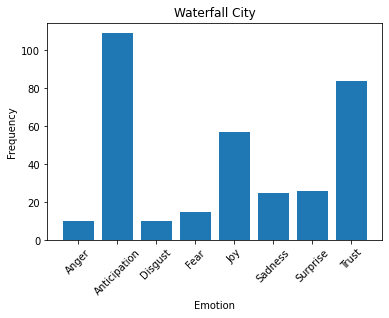

Processing Waterfall City_5.csv


ValueError: Wrong number of items passed 6, placement implies 1

In [23]:
for file in os.listdir('tweets'):
    print("Processing", file)
    df = pd.read_csv(f'tweets/{file}', lineterminator='\n') #line terminator prevents parsing error
    
    # Get VADER Compound value for sentiment intensity
    df['sentiment_intensity'] = [analyzer.polarity_scores(edited_tweet)['compound'] for edited_tweet in df['edited']]
    
    # Using pandas apply/lambda to speed up the process
    df['sentiment'] = df.apply(lambda x: get_sentiment(x['sentiment_intensity']),axis=1)
    
    #print(2)
    # Join all the edited tweets in one single string
    joined_string = join_edited_string(df['edited'])

    # Get tokens
    tokens = joined_string.split(' ')
    
    # We build now two dictionaries with indexes and unique words, for future reference
    unique_words = set(tokens)
    word_to_ind = dict((word, i) for i, word in enumerate(unique_words))
    ind_to_word = dict((i, word) for i, word in enumerate(unique_words))
    
    # We are using the NCR lexicon to associate words to emotions 
    # Be patient, this will take some time ...
    df, list_emotion_counts = get_tweet_emotions(df, emotions, 'edited')
    
    # Get all rows where no emotion was detected and remove them
    all_zeros = []
    for i in range(len(df)):
        all_zeros.append(df.Anger[i] == df.Anticipation[i] == df.Disgust[i] == df.Fear[i] == df.Joy[i] == df.Sadness[i] == df.Surprise[i] == df.Trust[i] == 0)

    df["all_zeros"] = all_zeros

    # Get indexes where all_zeros column has value True
    indexNames = df[df['all_zeros'] == True].index # Delete these row indexes from dataFrame
    df.drop(indexNames , inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.drop(columns=['all_zeros'], inplace=True)
    
    # Get the counts for the various emotions (found in the last 8 columns)
    emo_counts = {}
    for emo in df.columns[-8:]:
        emo_counts[emo] = df[emo].sum()
        
    emotions = list(emo_counts.keys())
    counts = list(emo_counts.values())
    
    plt.bar(emotions, counts)
    plt.title(file[:-4])# give a title to the plot
    plt.xlabel("Emotion")
    plt.ylabel("Frequency")
    plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    plt.show()

    # save newly edited df back to its file
    df.to_csv(f'tweets/{file}', index=False)

Processing Eko Atlantic.csv


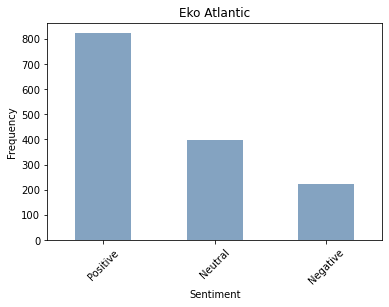

Processing Eko Atlantic_5.csv


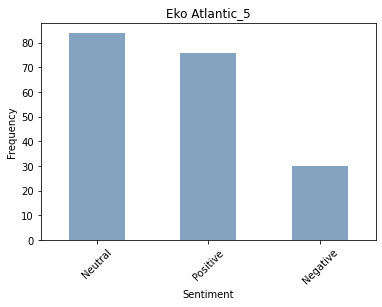

Processing Hope city.csv


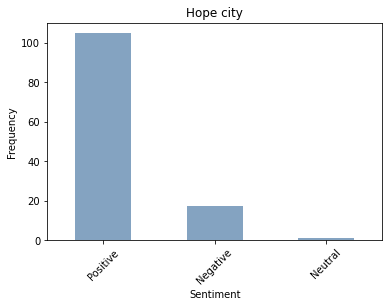

Processing Hope city_5.csv


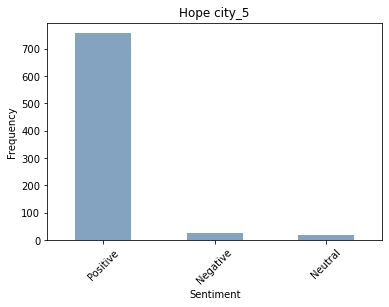

Processing Konza tech.csv


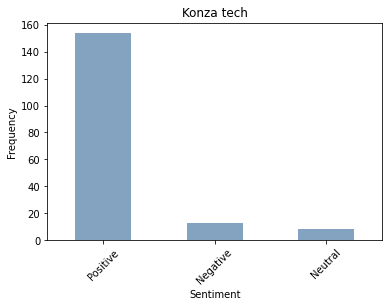

Processing Konza tech_5.csv


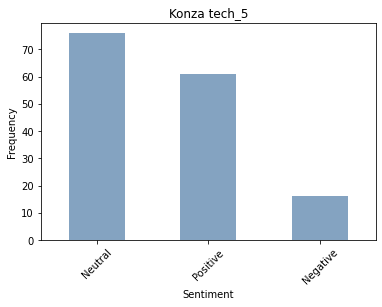

Processing Vision city.csv


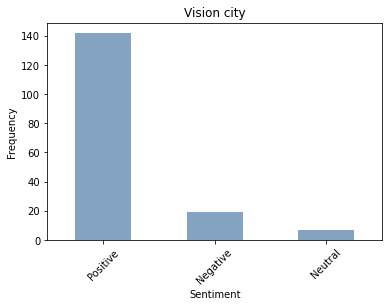

Processing Vision city_5.csv


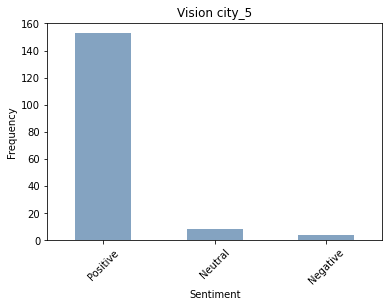

Processing Waterfall City.csv


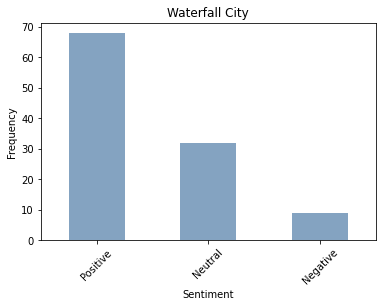

Processing Waterfall City_5.csv


KeyError: 'sentiment'

In [24]:
for file in os.listdir('tweets'):
    print("Processing", file)
    df = pd.read_csv(f'tweets/{file}', lineterminator='\n') #line terminator prevents parsing error
    
    df['sentiment'].value_counts().plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
    plt.title(file[:-4])# give a title to the plot
    plt.xlabel("Sentiment")
    plt.ylabel("Frequency")
    plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    plt.show()